<a href="https://colab.research.google.com/github/nursahmican/SQLite-and-Time-Series/blob/main/SQLite_and_TimeSeries_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
pip install pmdarima

In [53]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

***VERİ SETİ HAZIRLIK VE TEMİZLEME AŞAMALARI (EDA)***

In [54]:
# İlk excel dosyasını okuyup dataframe'e aldım:
excel_file = "RetailProduct.xlsx"
RetailProduct_df = pd.read_excel(excel_file)

print(RetailProduct_df)

   Prod_id DISTRIBUTOR Production        Pack_type
0     1746           X          A      SYRUP 150ML
1     2026           Y          B   A.IM 5MG 5 2ML
2     2027           Y          B    C.TAB 40MG 30
3     2028           Y          B    C.TAB 80MG 50
4    28633           Z          C    TABS 275MG 20
5    28699           Z          C    TABS 275MG 10
6    29249           Z          C  TABS 550MG F 10
7    29250           Z          C  TABS 550MG F 20
8    34480           Z          D    C.TAB 50MG 20
9   187242           Z          D       GEL 1% 50G


In [55]:
# Veri yönetimi ve analiz süreçlerini kolaylaştırmak için sütun isimlerini standardize ettim:
RetailProduct_df = RetailProduct_df.rename(columns={'Prod_id': 'prod_id','DISTRIBUTOR': 'distributor','Production': 'production', 'Pack_type': 'pack_type'})
print(RetailProduct_df)

# SQLite veritabanı oluşturdum:
conn = sqlite3.connect('veritabani.db')
cursor = conn.cursor()

# DataFrame'i SQLite tablosuna aktardım:
RetailProduct_df.to_sql('RetailProduct', conn, if_exists='replace', index=False)

   prod_id distributor production        pack_type
0     1746           X          A      SYRUP 150ML
1     2026           Y          B   A.IM 5MG 5 2ML
2     2027           Y          B    C.TAB 40MG 30
3     2028           Y          B    C.TAB 80MG 50
4    28633           Z          C    TABS 275MG 20
5    28699           Z          C    TABS 275MG 10
6    29249           Z          C  TABS 550MG F 10
7    29250           Z          C  TABS 550MG F 20
8    34480           Z          D    C.TAB 50MG 20
9   187242           Z          D       GEL 1% 50G


10

In [56]:
# İkinci excel dosyasını okuyup dataframe'e aldım:
excel_file1 = "MonthlyRetailSales.xlsx"
MonthlyRetailSales_df = pd.read_excel(excel_file1)

print(MonthlyRetailSales_df)

# Tarih bilgisi 2 ayrı sütunda tutulmuş, gereksiz yük oluşturacağını düşünerek sadece yıl ve ay içeren sütunu düşürüyorum.
MonthlyRetailSales_df = MonthlyRetailSales_df.drop(columns=['YEARMONTH'])

# Veri yönetimi ve analiz süreçlerini kolaylaştırmak için sütun isimlerini standardize ettim:
MonthlyRetailSales_df = MonthlyRetailSales_df.rename(columns={'MonthDate': 'month_date','Prod_id': 'prod_id', 'Units': 'units','TL': 'tl'})
print(MonthlyRetailSales_df)

# Burada verilerin doğru veri tipinde saklanıp saklanmadığını kontrol etmek ve null veri var mı görmek istedim:
print(MonthlyRetailSales_df.info())



       YEARMONTH  MonthDate  Prod_id   Units          TL
0        2021-01 2021-01-01    28744   20590   251198.00
1        2021-01 2021-01-01    28776     681    12162.66
2        2021-01 2021-01-01    28805   15493   204029.64
3        2021-01 2021-01-01    28863  132682  1729947.15
4        2021-01 2021-01-01    28866   14539   122230.94
...          ...        ...      ...     ...         ...
627403   2023-12 2023-12-01   131273       7      891.87
627404   2023-12 2023-12-01   131308       0        0.00
627405   2023-12 2023-12-01   131401      99    13473.90
627406   2023-12 2023-12-01   131424      24      922.20
627407   2023-12 2023-12-01   131427     351    23774.64

[627408 rows x 5 columns]
       month_date  prod_id   units          tl
0      2021-01-01    28744   20590   251198.00
1      2021-01-01    28776     681    12162.66
2      2021-01-01    28805   15493   204029.64
3      2021-01-01    28863  132682  1729947.15
4      2021-01-01    28866   14539   122230.94
...    

In [57]:
# Veri setimdeki Units ve TL sütunlarının temel istatistiki verilerini incelemek için bu fonksiyonu kullandım ve min değerlerde bir sorun olduğunu düşünüyorum negatif değer almamalı. 25% yani ilk çeyrekte 0'dan küçük olmamalı.
print(MonthlyRetailSales_df.describe())

                          month_date        prod_id         units  \
count                         627408  627408.000000  6.274080e+05   
mean   2022-06-16 12:00:00.000000256  112278.754533  1.225180e+04   
min              2021-01-01 00:00:00       6.000000 -1.526080e+05   
25%              2021-09-23 12:00:00   47881.500000  0.000000e+00   
50%              2022-06-16 00:00:00  127711.500000  3.800000e+01   
75%              2023-03-08 18:00:00  165318.500000  1.769000e+03   
max              2023-12-01 00:00:00  192684.000000  1.313118e+07   
std                              NaN   56757.990108  7.898081e+04   

                 tl  
count  6.274080e+05  
mean   6.006851e+05  
min   -1.243734e+07  
25%    0.000000e+00  
50%    3.088120e+03  
75%    1.403968e+05  
max    3.949075e+08  
std    3.230993e+06  


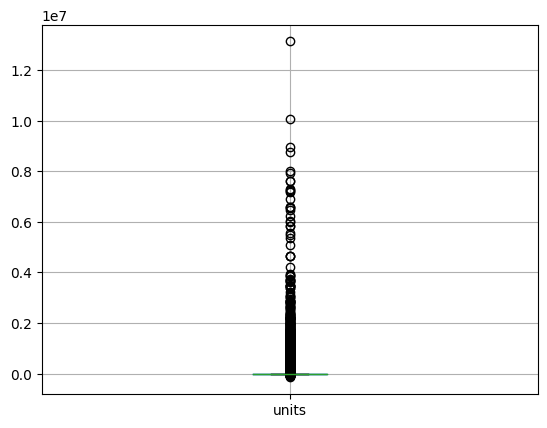

In [58]:
# Yukarıdaki istatistiki verilerden hatalı veya aykırı değerler olabileceği sonucunu çıkarmıştım. Units sütunundakileri belirlemek için :
# Boxplot ile uç değerleri görselleştiriyorum:

MonthlyRetailSales_df.boxplot(column=['units'])
plt.show()

# Uç değerleri filtreledim:
q1 = MonthlyRetailSales_df['units'].quantile(0.25)
q3 = MonthlyRetailSales_df['units'].quantile(0.75)
iqr = q3 - q1
MonthlyRetailSales_boxplot_df = MonthlyRetailSales_df[~((MonthlyRetailSales_df['units'] < (q1 - 1.5 * iqr)) | (MonthlyRetailSales_df['units'] > (q3 + 1.5 * iqr)))]

Units sütunundaki aykırı değerlere bakarak çok fazla satış miktarının olduğu yani 1.2 değerinin üzerindeki verilerde bir hata olduğu hakkında kesin yorum yapamıyorum çünkü herhangi bir ilacın diğer dönemlere nazaran yoğun kullanımını gerektiren dönemsel salgın vb. durumlar yaşanmış olabilir. Bu veriler hatalıdır ya da değildir diyebilmek için bu çok yüksek değerlerin ait olduğu döneme ait daha farklı verilere de ihtiyaç var. Bu nedenle bunları hatasız kabul ederek devam edeceğim.

Fakat 0'ın altındaki değerler hatalıdır ya da tarihi geçip firmaya geri gönderilen ilaçlar - değer olarak mı veritabanına kaydediliyor bilmiyorum. Bu sebeple bu - değerli verileri inceleyeceğim.


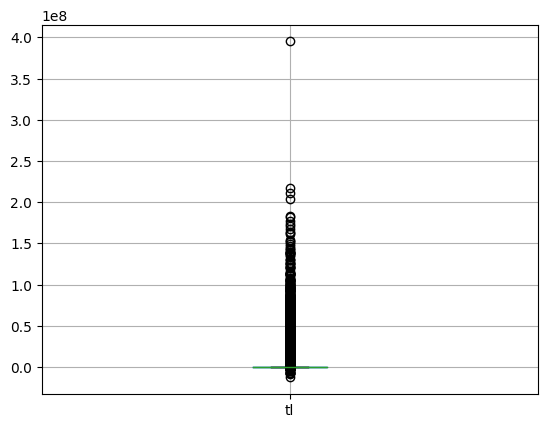

In [59]:
# Yukarıdaki istatistiki verilerden hatalı veya aykırı değerler olabileceği sonucunu çıkarmıştım. TL sütunundakileri de belirlemek için :
# Boxplot ile uç değerleri görselleştirdim:

MonthlyRetailSales_df.boxplot(column=['tl'])
plt.show()

# Uç değerleri filtreledim:
q1 = MonthlyRetailSales_df['tl'].quantile(0.25)
q3 = MonthlyRetailSales_df['tl'].quantile(0.75)
iqr = q3 - q1
MonthlyRetailSales_boxplott_df = MonthlyRetailSales_df[~((MonthlyRetailSales_df['tl'] < (q1 - 1.5 * iqr)) | (MonthlyRetailSales_df['tl'] > (q3 + 1.5 * iqr)))]

Burada TL ve Units sütunlarında negatif değerler aynı sayıda mı ve aynı satırlarda mı bunu inceleyeceğim.

In [60]:
negative_units = (MonthlyRetailSales_df['units'] < 0).sum()
negative_tl = (MonthlyRetailSales_df['tl'] < 0).sum()

negative_both = MonthlyRetailSales_df[(MonthlyRetailSales_df['units'] < 0) & (MonthlyRetailSales_df['tl'] < 0)]
negative_both_count = len(negative_both)

print(f"Units sütununda negatif değerlerin sayısı: {negative_units}")
print(f"TL sütununda negatif değerlerin sayısı: {negative_tl}")
print(f"Aynı satırlarda negatif Units ve TL değerlerinin sayısı: {negative_both_count}")

Units sütununda negatif değerlerin sayısı: 12846
TL sütununda negatif değerlerin sayısı: 12694
Aynı satırlarda negatif Units ve TL değerlerinin sayısı: 12405


In [61]:
# Units sütunu negatif olmayan ve TL sütunu negatif olan satırları filtreleme
only_negative_tl = MonthlyRetailSales_df[(MonthlyRetailSales_df['units'] >= 0) & (MonthlyRetailSales_df['tl'] < 0)]

print(only_negative_tl)

# TL sütunu negatif olmayan ve Units sütunu negatif olan satırları filtreleme
only_units_tl = MonthlyRetailSales_df[(MonthlyRetailSales_df['tl'] >= 0) & (MonthlyRetailSales_df['units'] < 0)]

print(only_units_tl)

       month_date  prod_id  units       tl
3453   2021-01-01    42520      1   -12.91
7039   2021-01-01   111107      0  -143.51
7802   2021-01-01   123326      0   -63.60
10194  2021-01-01   155073    107  -654.36
10921  2021-01-01   140286     43  -669.36
...           ...      ...    ...      ...
620006 2023-12-01    50121      0  -426.10
623508 2023-12-01   154430    118 -1803.00
623863 2023-12-01   175880      0  -450.00
625873 2023-12-01    36142      2  -276.68
626450 2023-12-01   135791     37 -4882.40

[289 rows x 4 columns]
       month_date  prod_id  units       tl
3522   2021-01-01    49976     -1     0.00
4497   2021-01-01    50382     -1     0.00
7812   2021-01-01   124836    -36   320.80
9003   2021-01-01   110952    -10   599.90
9185   2021-01-01   142354    -36     0.00
...           ...      ...    ...      ...
621924 2023-12-01   161492    -33   693.74
622037 2023-12-01   157623     -6     0.00
622266 2023-12-01   158460     -8     0.00
624810 2023-12-01   137283    

Bu satırlarda Units sayısı mı doğru Tl değeri mi doğru bilemedeğim için ve toplamda 730 (289 + 441)  satır yaklaşık 600k satırda yapılacak analizlerde çok büyük etkiler yapmayacağı için bu satırları düşüreceğim. Eğer 730 analiz sonuçlarını etkileyecek bir sayı olsaydı o zaman Units ya da TL sütünlarından hangisindeki değer doğruysa diğerinin hesaplaması aynı prod_id değerine sahip diğer satırlardaki TL/Units oranına göre doldurulabilirdi.

In [62]:
print(MonthlyRetailSales_df)

       month_date  prod_id   units          tl
0      2021-01-01    28744   20590   251198.00
1      2021-01-01    28776     681    12162.66
2      2021-01-01    28805   15493   204029.64
3      2021-01-01    28863  132682  1729947.15
4      2021-01-01    28866   14539   122230.94
...           ...      ...     ...         ...
627403 2023-12-01   131273       7      891.87
627404 2023-12-01   131308       0        0.00
627405 2023-12-01   131401      99    13473.90
627406 2023-12-01   131424      24      922.20
627407 2023-12-01   131427     351    23774.64

[627408 rows x 4 columns]


In [63]:
# Units sütunu negatif olmayan ve TL sütunu negatif olan satırları düşürme
MonthlyRetailSales_df = MonthlyRetailSales_df.drop(MonthlyRetailSales_df[(MonthlyRetailSales_df['units'] >= 0) & (MonthlyRetailSales_df['tl'] < 0)].index)

print(MonthlyRetailSales_df)

# TL sütunu negatif olmayan ve Units sütunu negatif olan satırları düşürme
MonthlyRetailSales_df = MonthlyRetailSales_df.drop(MonthlyRetailSales_df[(MonthlyRetailSales_df['tl'] >= 0) & (MonthlyRetailSales_df['units'] < 0)].index)

print(MonthlyRetailSales_df)

       month_date  prod_id   units          tl
0      2021-01-01    28744   20590   251198.00
1      2021-01-01    28776     681    12162.66
2      2021-01-01    28805   15493   204029.64
3      2021-01-01    28863  132682  1729947.15
4      2021-01-01    28866   14539   122230.94
...           ...      ...     ...         ...
627403 2023-12-01   131273       7      891.87
627404 2023-12-01   131308       0        0.00
627405 2023-12-01   131401      99    13473.90
627406 2023-12-01   131424      24      922.20
627407 2023-12-01   131427     351    23774.64

[627119 rows x 4 columns]
       month_date  prod_id   units          tl
0      2021-01-01    28744   20590   251198.00
1      2021-01-01    28776     681    12162.66
2      2021-01-01    28805   15493   204029.64
3      2021-01-01    28863  132682  1729947.15
4      2021-01-01    28866   14539   122230.94
...           ...      ...     ...         ...
627403 2023-12-01   131273       7      891.87
627404 2023-12-01   131308       

In [64]:
# Hem Units hem TL değeri negatif olan 12405 satır üzerindeki işlemlerim:

print(negative_both)
# TL/Units hesabını yaparak birim fiyatı gösteren yeni bir sütun ekledim:
negative_both['tl_per_units'] = negative_both['tl'] / negative_both['units']

print(negative_both)

       month_date  prod_id  units       tl
29     2021-01-01    29766     -6   -27.45
46     2021-01-01    32629    -18  -237.06
68     2021-01-01    33891     -1   -16.88
72     2021-01-01    33952    -23  -188.83
160    2021-01-01    37506     -2   -52.64
...           ...      ...    ...      ...
627207 2023-12-01   154431     -4   -60.09
627240 2023-12-01   113570     -1  -138.41
627287 2023-12-01   122853     -1   -55.93
627332 2023-12-01   127865     -2  -353.90
627401 2023-12-01   131192    -44 -4455.92

[12405 rows x 4 columns]
       month_date  prod_id  units       tl  tl_per_units
29     2021-01-01    29766     -6   -27.45      4.575000
46     2021-01-01    32629    -18  -237.06     13.170000
68     2021-01-01    33891     -1   -16.88     16.880000
72     2021-01-01    33952    -23  -188.83      8.210000
160    2021-01-01    37506     -2   -52.64     26.320000
...           ...      ...    ...      ...           ...
627207 2023-12-01   154431     -4   -60.09     15.022500
62

In [65]:
# Aynı prod_id değerine sahip yani aynı ürünlerin birim fiyatları aynı olmalıdır diye düşünerek bi kontrol etmek istedim:
unique_values_per_prod_id = negative_both.groupby('prod_id')['tl_per_units'].nunique()

print(unique_values_per_prod_id)

# 1'den farklı olanları filtrelemek
filtered_results = unique_values_per_prod_id[unique_values_per_prod_id > 1]

print(filtered_results)

prod_id
67        2
80        1
86        1
88        1
156       1
         ..
186595    1
186694    1
186696    1
186697    1
188519    1
Name: tl_per_units, Length: 4394, dtype: int64
prod_id
67         2
210        5
354       10
644        4
690        2
          ..
181152     2
181312     2
181493     2
182837     2
184993     2
Name: tl_per_units, Length: 2030, dtype: int64


Burada aynı prod_id değerine sahip olan ürünlerin yani aynı ürünlerin birim fiyatını grupluyorum, aynı ürünlerin birim fiyatları aynı olmalı varsayımından giderek. Fakat dönemsel olarak ilaçların fiyatları değişiklik göstermiş olabilir bunu belirlemek için farklı verilere ihtiyacım var fakat daha fazla veri kaybı yaşamak istemediğim için fiyatlarda dönemsel değişiklik varsayımını kabul ederek bu satırları düşürmemeye karar verdim.

In [66]:
# DataFrame'i SQLite tablosuna aktar
MonthlyRetailSales_df.to_sql('MonthlyRetailSales', conn, if_exists='replace', index=False)

626678

***SORU*** ***1***

In [67]:
# "Z" distribütörünün Ürünlerinin toplam satışlarını (TL) getiren SQL sorgusu:

query_toplam_satislar = """SELECT
    f.prod_id,
    SUM(f.tl) AS ToplamSatis
FROM
    MonthlyRetailSales f
JOIN
    RetailProduct d
ON
    f.prod_id = d.prod_id
WHERE
    d.distributor = 'Z'
GROUP BY
    f.prod_id;
"""
# Sorguyu çalıştır ve sonuçları al
toplam_satislar_df = pd.read_sql_query(query_toplam_satislar, conn)

# Sonuçları görüntüle
print(toplam_satislar_df)

   prod_id   ToplamSatis
0    28633  1.365467e+07
1    28699  6.165674e+06
2    29249  9.854311e+07
3    29250  4.592867e+08
4    34480  1.396540e+09
5   187242  1.785168e+05


In [68]:
# Z distribütör'üne ait tüm ürünlerin toplam satışı:

query_toplam_satis = """SELECT SUM(f.tl) AS ToplamSatis
FROM MonthlyRetailSales f
JOIN RetailProduct d ON f.prod_id = d.prod_id
WHERE d.distributor = 'Z';
"""

# Sorguyu çalıştır ve sonuçları al
toplam_satis_df = pd.read_sql_query(query_toplam_satis, conn)

# Sonuçları görüntüle
print(toplam_satis_df)

    ToplamSatis
0  1.974369e+09


***SORU 2***

In [69]:
# 2023 yılı içerisinde aylık Bazda D ürününün satış miktarını (TL)  veren SQL sorgusu
query_2023_d = "SELECT strftime('%Y-%m', s.month_date) AS YilAy, SUM(s.TL) AS ToplamSatis FROM MonthlyRetailSales s JOIN RetailProduct p ON s.prod_id = p.prod_id WHERE  p.production = 'D'  AND strftime('%Y', s.month_date) = '2023' GROUP BY strftime('%Y-%m', s.month_date) ORDER BY strftime('%Y-%m', s.month_date)"

# Sorguyu çalıştır ve sonuçları al
df_2023_d = pd.read_sql_query(query_2023_d, conn)

# Sonuçları görüntüle
print(df_2023_d)

      YilAy   ToplamSatis
0   2023-01  3.100435e+07
1   2023-02  1.950426e+07
2   2023-03  1.822660e+08
3   2023-04  8.194261e+06
4   2023-05  1.704438e+07
5   2023-06  1.829125e+08
6   2023-07  1.723525e+07
7   2023-08  1.390256e+07
8   2023-09  1.680661e+08
9   2023-10  1.314245e+07
10  2023-11  2.318497e+07
11  2023-12  2.172338e+08


In [70]:
# 2023 yılı içerisinde aylık Bazda D ürününün satış miktarını (TL)  veren SQL sorgusu
# (Biri GEL biri Tab olmak üzere 2 farklı D ürünü için ayrı ayrı satış miktarını (TL) veren SQL sorgusu)
query_2023_d_farkli_pack = """
SELECT
    strftime('%Y-%m', s.month_date) AS YilAy,
    s.prod_id,
    SUM(s.tl) AS ToplamSatis
FROM
    MonthlyRetailSales s
JOIN
    RetailProduct f ON s.prod_id = f.prod_id
WHERE
    f.production = 'D'
    AND strftime('%Y', s.month_date) = '2023'
GROUP BY
    strftime('%Y-%m', s.month_date),
    s.prod_id
ORDER BY
    s.prod_id,
    strftime('%Y-%m', s.month_date);
"""

# Sorguyu çalıştır ve sonuçları al
df_2023_d_farkli_pack = pd.read_sql_query(query_2023_d_farkli_pack, conn)

# Sonuçları görüntüle
print(df_2023_d_farkli_pack)

      YilAy  prod_id   ToplamSatis
0   2023-01    34480  3.100435e+07
1   2023-02    34480  1.950426e+07
2   2023-03    34480  1.822660e+08
3   2023-04    34480  8.194261e+06
4   2023-05    34480  1.704438e+07
5   2023-06    34480  1.829125e+08
6   2023-07    34480  1.723525e+07
7   2023-08    34480  1.390256e+07
8   2023-09    34480  1.680661e+08
9   2023-10    34480  1.314245e+07
10  2023-11    34480  2.318497e+07
11  2023-12    34480  2.170553e+08
12  2023-01   187242  0.000000e+00
13  2023-02   187242  0.000000e+00
14  2023-03   187242  0.000000e+00
15  2023-04   187242  0.000000e+00
16  2023-05   187242  0.000000e+00
17  2023-06   187242  0.000000e+00
18  2023-07   187242  0.000000e+00
19  2023-08   187242  0.000000e+00
20  2023-09   187242  0.000000e+00
21  2023-10   187242  0.000000e+00
22  2023-11   187242  0.000000e+00
23  2023-12   187242  1.785168e+05


***SORU*** ***3***

In [71]:
# 2022 yılından 2023 yılının sonuna kadar Aylık Bazda Z distribütörünün Pazar Payını getiren SQL sorgusunu yazınız
query_2022_2023_pazar_payi = """
SELECT
    strftime('%Y-%m', s.month_date) AS YilAy,
    SUM(CASE WHEN p.distributor = 'Z' THEN s.tl ELSE 0 END) * 1.0 / SUM(s.tl) AS PazarPayi
FROM
    MonthlyRetailSales s
JOIN
    RetailProduct p
ON
    s.prod_id = p.prod_id
WHERE
    strftime('%Y', s.month_date) >= '2022'
    AND strftime('%Y', s.month_date) <= '2023'
GROUP BY
    strftime('%Y-%m', s.month_date)
ORDER BY
    strftime('%Y-%m', s.month_date)
"""

pazar_payi_2022_2023_df = pd.read_sql_query(query_2022_2023_pazar_payi, conn)
print(pazar_payi_2022_2023_df)

      YilAy  PazarPayi
0   2022-01   0.969499
1   2022-02   0.971276
2   2022-03   0.993850
3   2022-04   0.940019
4   2022-05   0.972111
5   2022-06   0.997130
6   2022-07   0.959176
7   2022-08   0.962433
8   2022-09   0.996335
9   2022-10   0.957546
10  2022-11   0.981968
11  2022-12   0.988428
12  2023-01   0.979285
13  2023-02   0.978472
14  2023-03   0.997134
15  2023-04   0.965108
16  2023-05   0.978054
17  2023-06   0.998057
18  2023-07   0.974954
19  2023-08   0.972752
20  2023-09   0.996686
21  2023-10   0.969691
22  2023-11   0.979231
23  2023-12   0.997690


***SORU 4***

Bu soruda öncelikle dataframelerim üzerinde bazı işlemler yaptıktan sonra tahminleme için zaman serisi modellerinden ARIMA modelini kullanacağım.

In [72]:
print(RetailProduct_df)
print(MonthlyRetailSales_df)

   prod_id distributor production        pack_type
0     1746           X          A      SYRUP 150ML
1     2026           Y          B   A.IM 5MG 5 2ML
2     2027           Y          B    C.TAB 40MG 30
3     2028           Y          B    C.TAB 80MG 50
4    28633           Z          C    TABS 275MG 20
5    28699           Z          C    TABS 275MG 10
6    29249           Z          C  TABS 550MG F 10
7    29250           Z          C  TABS 550MG F 20
8    34480           Z          D    C.TAB 50MG 20
9   187242           Z          D       GEL 1% 50G
       month_date  prod_id   units          tl
0      2021-01-01    28744   20590   251198.00
1      2021-01-01    28776     681    12162.66
2      2021-01-01    28805   15493   204029.64
3      2021-01-01    28863  132682  1729947.15
4      2021-01-01    28866   14539   122230.94
...           ...      ...     ...         ...
627403 2023-12-01   131273       7      891.87
627404 2023-12-01   131308       0        0.00
627405 2023-12-0

In [73]:
# Sadece 2022 ve 2023 yıllarına ait verileri filtreledim:
df_2022_2023 = MonthlyRetailSales_df[(MonthlyRetailSales_df['month_date'].dt.year == 2022) | (MonthlyRetailSales_df['month_date'].dt.year == 2023)]
print(df_2022_2023)

       month_date  prod_id  units          tl
209136 2022-01-01   130258   1690    64533.70
209137 2022-01-01   130348     90     3531.92
209138 2022-01-01   130557    193     7316.40
209139 2022-01-01   130589    108    32149.44
209140 2022-01-01   130592   2320  1638566.00
...           ...      ...    ...         ...
627403 2023-12-01   131273      7      891.87
627404 2023-12-01   131308      0        0.00
627405 2023-12-01   131401     99    13473.90
627406 2023-12-01   131424     24      922.20
627407 2023-12-01   131427    351    23774.64

[417798 rows x 4 columns]


In [74]:
# RetailProduct dataframe'inden C ürünlerinin prod_id değerlerini bir listeye çekiyorum:
prod_id_values = RetailProduct_df.loc[RetailProduct_df['production'] == 'C', 'prod_id'].tolist() # C ürünlerinin prod_id değerleri

# Bu prod_id'lere sahip ürünleri MonthlyRetailSales dataframe'den filtrelediğim 2022-2023 verilerinin bulunduğu dataframe'den filtreliyorum:
c_df = df_2022_2023[df_2022_2023['prod_id'].isin(prod_id_values)]
print(c_df)

# prod_id değerlerine göre C'ların ortalama ve ortanca değerlerini hesaplıyorum:
c_df.groupby('prod_id').agg(['mean','median'])

       month_date  prod_id    units           tl
215145 2022-01-01    28699    22249     84671.73
216922 2022-01-01    29250   264657   3274069.89
217862 2022-01-01    29249    91787    777310.72
217961 2022-01-01    28633    23610    196557.92
227997 2022-02-01    28633    22120    187552.16
...           ...      ...      ...          ...
600589 2023-11-01    29250   192597  11542406.04
611347 2023-12-01    28699    15112    396696.32
625312 2023-12-01    28633    19732    948319.92
625768 2023-12-01    29250  1267200  66111002.82
625908 2023-12-01    29249   297448  12720088.26

[96 rows x 4 columns]


month_date                              units                      tl  \
              mean              median           mean    median          mean   
prod_id                                                                         
28633   2022-12-16 2022-12-16 12:00:00   19100.375000   18184.0  4.921297e+05   
28699   2022-12-16 2022-12-16 12:00:00   17111.500000   16151.5  2.238968e+05   
29249   2022-12-16 2022-12-16 12:00:00  146539.416667   84838.5  3.508468e+06   
29250   2022-12-16 2022-12-16 12:00:00  514997.458333  229978.5  1.638504e+07   

                      
              median  
prod_id               
28633     462176.815  
28699     230618.810  
29249    2610728.110  
29250    8978613.375

Burada 28633 ve 28699 prod_id'li yani 275mglik C ürünlerinin medyan ve ortalamalarının birbirine yakın olduğunu görüyoruz bu da verilerin düzgün dağıldığını ve aykırı değerlerin az olduğunu gösteriyor. Yani her ay aşağı yukarı yakın miktarlarda satış olduğunu çıkarıyoruz.

In [75]:
# Her bir prod_id için ayrı ayrı dataframe oluşturdum, her Z tipi için ayrı ayrı satış tahmini yapacağım.
for prod_id in prod_id_values:
    globals()[f"df_2022_2023_{prod_id}"] = df_2022_2023[df_2022_2023['prod_id'] == prod_id]
    print(f"df_2022_2023_{prod_id}:\n", globals()[f"df_2022_2023_{prod_id}"], "\n")

df_2022_2023_28633:
        month_date  prod_id  units         tl
217961 2022-01-01    28633  23610  196557.92
227997 2022-02-01    28633  22120  187552.16
251589 2022-03-01    28633  15296  178198.40
274619 2022-04-01    28633  15251  177685.80
289876 2022-05-01    28633  21024  240456.00
311625 2022-06-01    28633  19021  221722.80
321894 2022-07-01    28633  17271  276524.72
331618 2022-08-01    28633  19292  308848.91
357127 2022-09-01    28633  21398  339572.10
373484 2022-10-01    28633  21531  344775.35
388860 2022-11-01    28633  30376  486335.77
416802 2022-12-01    28633  26447  423416.47
426668 2023-01-01    28633  17118  561983.94
440869 2023-02-01    28633  13342  438017.86
453197 2023-03-01    28633  20257  733616.77
481357 2023-04-01    28633  14831  546188.90
490168 2023-05-01    28633  18309  674283.64
505552 2023-06-01    28633  15973  588617.06
523164 2023-07-01    28633  17965  661466.80
540331 2023-08-01    28633  16326  784627.56
557869 2023-09-01    28633  16533 

<ipython-input-76-4bc14756ce8f>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_2022_2023_28633["units"], color = 'y')


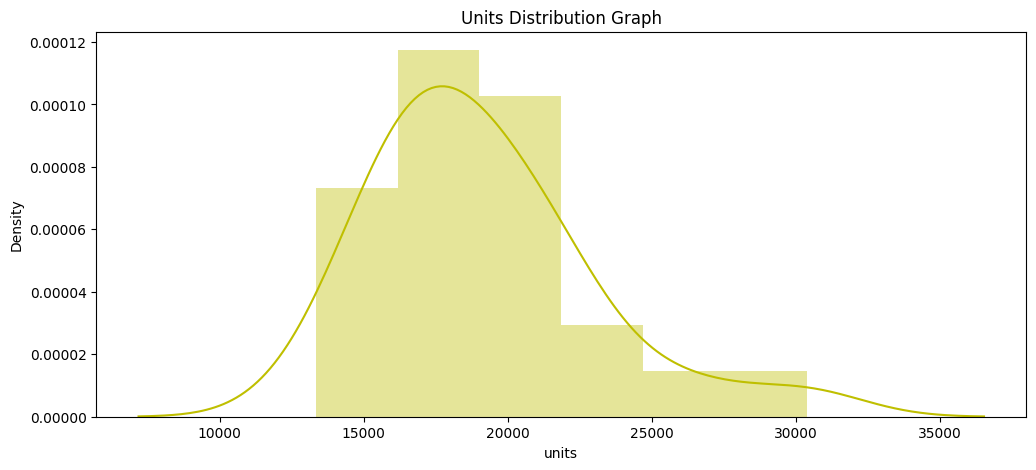

In [76]:
# TABS 275MG 20 / 28633 prod_id'li Z için  için:
# month_date sütununu index'e alıyorum:

df_2022_2023_28633= df_2022_2023_28633.set_index(['month_date'])

# Satışların dağılımını görmek için bir grafik çizdirdim :

plt.figure(figsize=(12,5))
plt.title("Units Distribution Graph")
ax = sns.distplot(df_2022_2023_28633["units"], color = 'y')

Satış miktarları çok büyük bir aralıkta dağılmamış, nadiren de olsa yüksek miktarlar da satışın olduğu dönemler olmuş. Bu dönemlerdeki satışı etkileyen faktörler farklı veriler de ele alınarak incelenebilir.

In [77]:

# Verilerin durağan olup olmadığından emin olmak için aşağıdaki fonksiyonu kullanıyorum. Zaman serilerinde durağanlık zaman içerisinde varyansın ve ortalamanın sabit olmasıdır.
def ad_test(dataset):

    dftest = adfuller(dataset, autolag = 'AIC')

    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
         print("\t",key, ": ", val)


ad_test(df_2022_2023_28633['tl'])

1. ADF :  1.1115606626977774
2. P-Value :  0.995314090392309
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression: 14
5. Critical Values :
	 1% :  -4.01203360058309
	 5% :  -3.1041838775510207
	 10% :  -2.6909873469387753


P <0.05 ise; Veriler durağandır.

p> 0.05 ise; Veriler durağan değildir.

Burada verilerimizin durağan olmadığını görüyoruz.Bu verileri durağan hale getirmek için ARIMA Modelin “d” değerini 1 vermemiz gerekiyor.

ARIMA modelini oluştururken 3 parametre verilir bunlar sırasıyla; p,d ve q.

p: x(t) anında kaç adım önceki değerlerin tahmin işleminde göz önüne alınacağını, q: x(t) anındaki bir tahmin hatasının kaç adım önceki değerler ile moving average işlemine tabi tutulacağını, d: veriyi durağan hale getirmek için uygulanacak fark alma işlemi derecesini ifade ediyor.

auto_arima fonksiyonu ile belirli bir tahmin modelinin ne kadar iyi olduğuna karar vermek için temel olarak AIC puanını kullanır. Yalnızca AIC puanını en aza indirmeye çalışır.

In [78]:
# En iyi arıma modeli için en optimum parametreleri seçmek için auto_arima fonksiyonunu kullandım :
stepwise_fit = auto_arima(df_2022_2023_28633['tl'], trace=True, suppress_warnings=True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=598.932, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=577.629, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=597.273, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=599.281, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=579.059, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=579.522, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=581.195, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=590.328, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.496 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -285.814
Date:                Sun, 07 Jul 2024   AIC                   


Model Özeti
Bağımlı Değişken: y
Model: SARIMAX(1, 1, 0)
Örneklem: 01-01-2022'den 12-01-2023'e (24 gözlem)


Model Parametreleri
Kesme: Tahmini kesme noktası 58.510 olup, tüm diğer değişkenler sıfır olduğunda bağımlı değişken y'nin ortalama değerini temsil eder.
AR(1): Otoregresif parametre (AR.L1) -0.7608 olup, y'nin mevcut değeri ile önceki değeri arasında güçlü bir negatif ilişki olduğunu gösterir. Bu, zaman serisinde yüksek derecede negatif otokorelasyon olduğunu işaret eder.
Sigma2: Hata teriminin tahmini varyansı 3.446e+09 olup, bağımlı değişken y'deki açıklanamayan varyansı temsil eder.

Diagnostik Testler
Ljung-Box (Q) Testi: Ljung-Box test istatistiği 1.02 olup, p-değeri 0.31'dir. Bu, artık değerlerde önemli bir otokorelasyon olmadığını, modelin verilerin zamansal yapısını yeterince yakaladığını gösterir.
Jarque-Bera (JB) Testi: Jarque-Bera test istatistiği 2.10 olup, p-değeri 0.35'dir. Bu, artık değerlerin normal dağıldığını, modelin geçerliliği için önemli bir varsayımı işaret eder.
Heteroskedastisite (H) Testi: Heteroskedastisite test istatistiği 1.60 olup, p-değeri 0.52'dir. Bu, artık değerlerin sabit bir varyansa sahip olduğunu, model için başka bir önemli varsayımı işaret eder.

Genel olarak, model verileri iyi bir şekilde uyarlamış görünmektedir ve diagnostik testler model varsayımlarının karşılandığını göstermektedir. Güçlü negatif otoregresif parametre, zaman serisinin yüksek derecede negatif otokorelasyon sergilediğini ve modelin bunu etkili bir şekilde yakaladığını göstermektedir.



 Datasetimi eğitim ve test setlerine ayırıyorum. Öncelikle elimdeki verileri en iyi skoru verecek olan ARIMA(1,1,0) parametreleri ile test ve train olarak bölerek bir model eğitmek istiyorum, sonuçları görsel olarak da görmek istiyorum.


In [79]:
train = df_2022_2023_28633['tl'][:18]  # İlk 18 ay eğitim seti
test = df_2022_2023_28633['tl'][18:]   # Son 6 ay test seti

# ARIMA modelini fit etme ve tahmin yapma
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=645156.635818, expected=661466.800000
predicted=612983.841027, expected=784627.560000
predicted=708626.259000, expected=791692.380000
predicted=787597.148076, expected=867915.540000
predicted=823889.750673, expected=832735.620000
predicted=852970.340326, expected=948319.920000


Çıktı değerlerinden de görebileceğimiz gibi, kurulmuş olan ARIMA modelinin tahmin değerleriyle beklenen değerler arasında büyük farklılıklar çıkmadı. Bundan sonraki adımda kurduğum modelin performans değerlendirmesi için mae, rmse gibi istatistiki değerleri hesaplayacağım:


In [80]:
# Tahminler ve gerçek değerler
predicted = np.array(predictions)
expected = np.array(test)

# Hata metriklerini hesapladım:
mae = np.mean(np.abs(predicted - expected))
mse = np.mean((predicted - expected) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predicted - expected) / expected)) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 75922.30751357041
RMSE: 93317.02596182104
MAPE: 9.2008028009812


MAE ve RMSE değerleri: modelinizin tahminlerinin genel doğruluğunu gösteriyor, TL değerlerimiz geniş aralıkta olduğu için, bu hata değerlerinin kabul edilebilir olduğunu düşünebiliriz.
MAPE değeri %9.20 gibi bir değer ürün satışı gibi tahminlerde genellikle kabul edilebilir bir sapma düzeyidir.


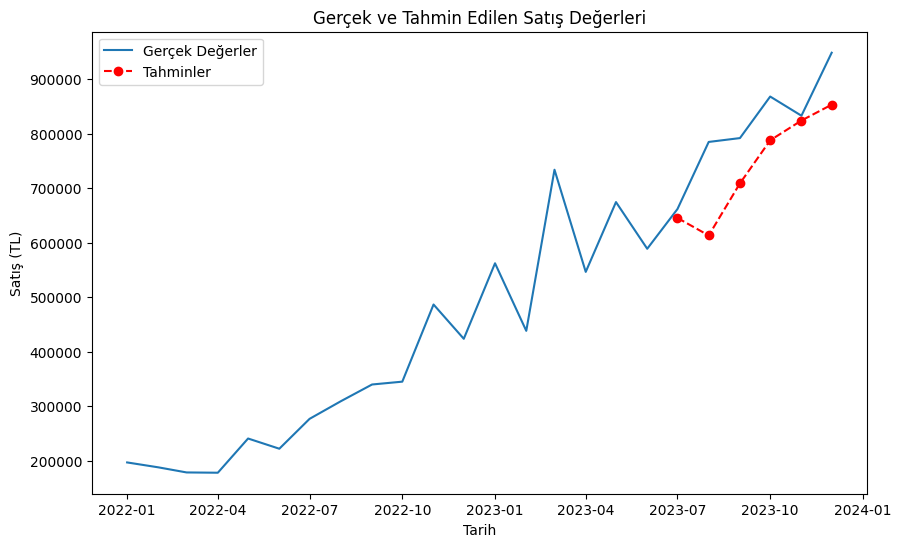

In [81]:
# Tahmin sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(df_2022_2023_28633.index, df_2022_2023_28633['tl'], label='Gerçek Değerler')
plt.plot(test.index, predictions, color='red', marker='o', linestyle='dashed', label='Tahminler')
plt.xlabel('Tarih')
plt.ylabel('Satış (TL)')
plt.title('Gerçek ve Tahmin Edilen Satış Değerleri')
plt.legend()
plt.show()

Çizgiler tam olarak örtüşmese de tahmin edilen satış değerleri ve gerçek satış değerlerinin zamana bağlı yükseliş ve düşüş trendleri birbiriyle çoğunlukla uyumlu bir patern sergilemektedir. Bu da over-fitting'in önüne geçilmesi açısından iyi bir sonuç olarak değerlendirilebilir.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model Tahminleri:
2024-01-01    880456.320983
2024-02-01    920301.421672
2024-03-01    896906.964674
2024-04-01    910642.671417
2024-05-01    902577.955927
2024-06-01    907313.033427
Freq: MS, Name: predicted_mean, dtype: float64


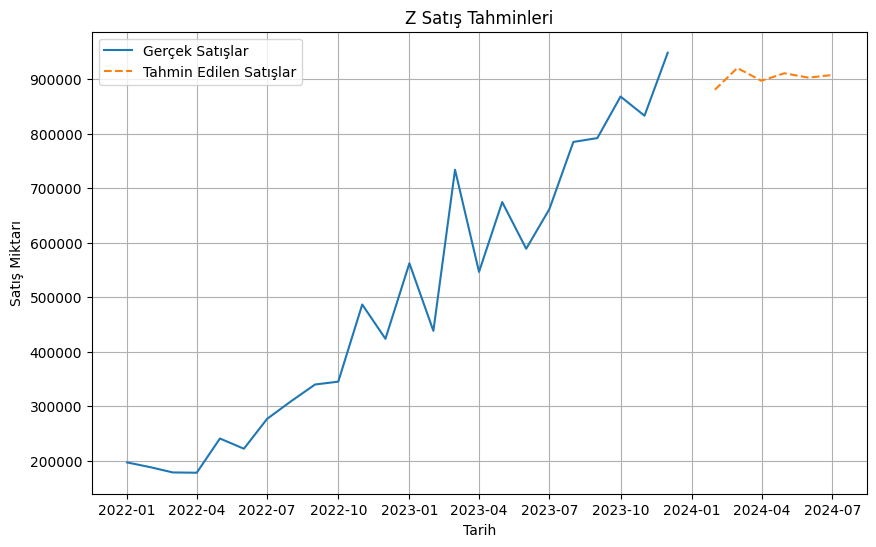

In [82]:
model = ARIMA(df_2022_2023_28633['tl'], order=(1,1,0))
results = model.fit()

# Gelecekteki 6 aylık satışları tahmin etme
forecast = results.forecast(steps=6)

# Tahmin sonuçlarını ve tahmin aralıklarını yazdırma
print("ARIMA Model Tahminleri:")
print(forecast)

# Tahmin sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(df_2022_2023_28633.index, df_2022_2023_28633['tl'], label='Gerçek Satışlar')
plt.plot(pd.date_range(start='2024-01-01', periods=6, freq='M'), forecast, label='Tahmin Edilen Satışlar', linestyle='--')
plt.title('Z Satış Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Satış Miktarı')
plt.legend()
plt.grid(True)
plt.show()

***TÜM BU ADIMLARI DİĞER C ÜRÜNLERİNDE DE KULLANABİLMEK İÇİN BİR FONKSİYONA ALIYORUM: ***

In [83]:
def process_sales_data(df, prod_id_value):
    df= df.set_index(['month_date'])

    # Satış dağılım grafiği çizme
    plt.figure(figsize=(12,5))
    plt.title(f"Units Distribution Graph for prod_id {prod_id_value}")
    sns.distplot(df["units"], color='y')
    plt.show()

    # Durağanlık testi (ADF Testi)
    def ad_test(dataset):
        dftest = adfuller(dataset, autolag='AIC')
        print(f"ADF Test Results for prod_id {prod_id_value}:")
        print("1. ADF : ", dftest[0])
        print("2. P-Value : ", dftest[1])
        print("3. Num Of Lags : ", dftest[2])
        print("4. Num Of Observations Used For ADF Regression:", dftest[3])
        print("5. Critical Values :")
        for key, val in dftest[4].items():
            print("\t", key, ": ", val)

    ad_test(df['tl'])

    # ARIMA model fitting and summary
    stepwise_fit = auto_arima(df['tl'], trace=True, suppress_warnings=True)
    print(stepwise_fit.summary())

    # En iyi modelin (p, d, q) değerlerini alıyorum:
    best_order = stepwise_fit.order

    # Training and test data
    train = df['tl'][:18]  # İlk 18 ay eğitim seti
    test = df['tl'][18:]   # Son 6 ay test seti

    # ARIMA modelini fit etme ve tahmin yapma
    history = [x for x in train]
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print(f'predicted={yhat}, expected={obs}')

    # Tahminler ve gerçek değerler
    predicted = np.array(predictions)
    expected = np.array(test)

    # Hata metriklerini hesapladım:
    mae = np.mean(np.abs(predicted - expected))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((predicted - expected) / expected)) * 100

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

    # Tahmin sonuçlarını görselleştirme
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['tl'], label='Gerçek Değerler')
    plt.plot(test.index, predictions, color='red', marker='o', linestyle='dashed', label='Tahminler')
    plt.xlabel('Tarih')
    plt.ylabel('Satış (TL)')
    plt.title(f'Gerçek ve Tahmin Edilen Satış Değerleri for prod_id {prod_id_value}')
    plt.legend()
    plt.show()

    # Gelecekteki 6 aylık satışları tahmin etme
    model = ARIMA(df['tl'], order=best_order)
    results = model.fit()
    forecast = results.forecast(steps=6)

    # Tahmin sonuçlarını ve tahmin aralıklarını yazdırma
    print(f"ARIMA Model Tahminleri for prod_id {prod_id_value}:")
    print(forecast)

    # Tahmin sonuçlarını görselleştirme
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['tl'], label='Gerçek Satışlar')
    plt.plot(pd.date_range(start='2024-01-01', periods=6, freq='M'), forecast, label='Tahmin Edilen Satışlar', linestyle='--')
    plt.title(f'Z Satış Tahminleri for prod_id {prod_id_value}')
    plt.xlabel('Tarih')
    plt.ylabel('Satış Miktarı')
    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-83-f8460e3c9492>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["units"], color='y')


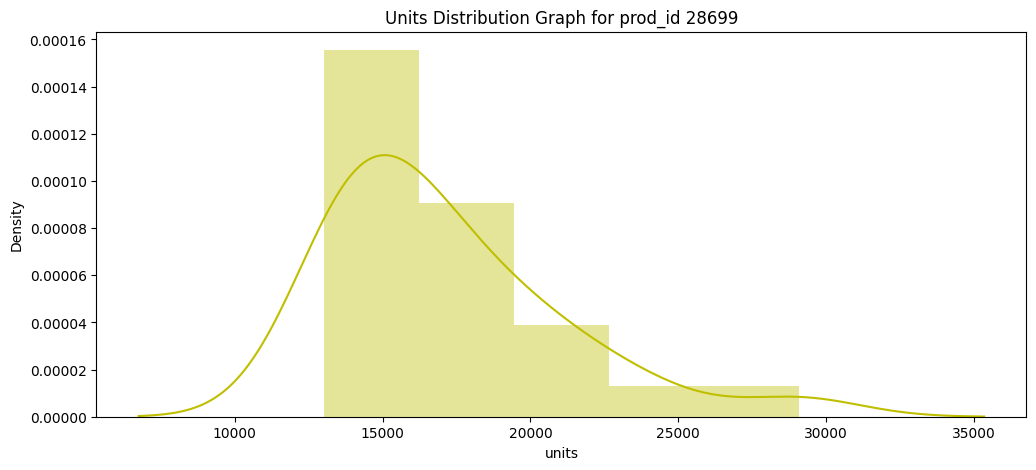

ADF Test Results for prod_id 28699:
1. ADF :  -0.25433986873221537
2. P-Value :  0.9317268384308353
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression: 19
5. Critical Values :
	 1% :  -3.8326031418574136
	 5% :  -3.0312271701414204
	 10% :  -2.655519584487535
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=562.542, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=543.128, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=558.423, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=562.531, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=545.180, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=545.170, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=547.103, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=553.359, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.760 seconds
                       

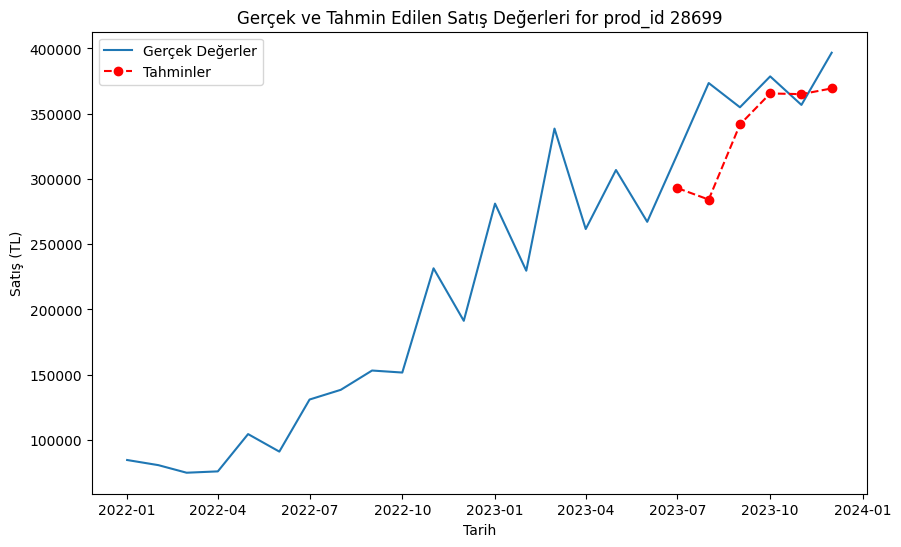

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model Tahminleri for prod_id 28699:
2024-01-01    373135.653962
2024-02-01    387016.832147
2024-03-01    378838.493407
2024-04-01    383656.904615
2024-05-01    380818.053436
2024-06-01    382490.612225
Freq: MS, Name: predicted_mean, dtype: float64


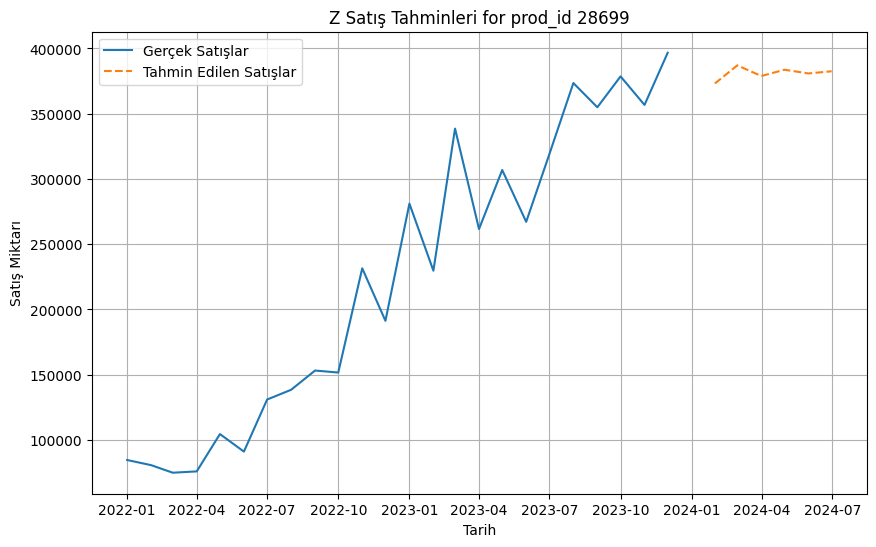

In [84]:
# TABS 275MG 10 Z için:
process_sales_data(df_2022_2023_28699, 28699)


<ipython-input-83-f8460e3c9492>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["units"], color='y')


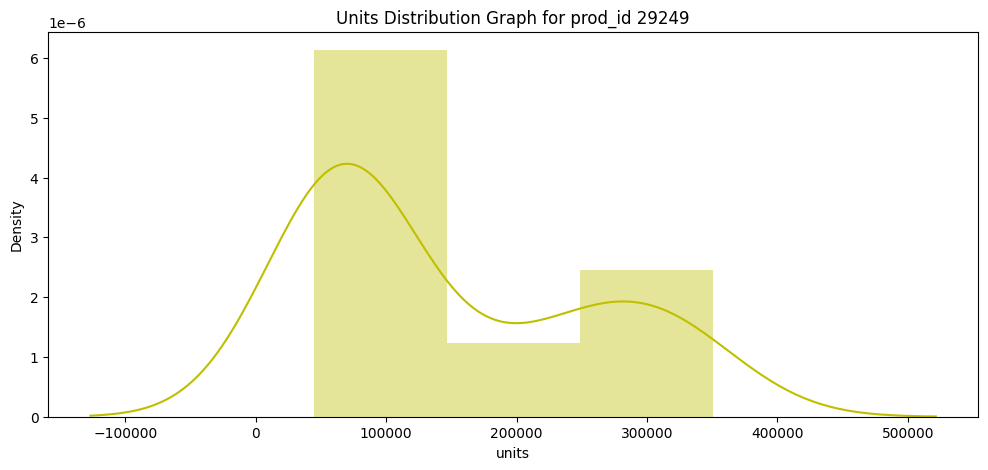

ADF Test Results for prod_id 29249:
1. ADF :  0.8117897916077608
2. P-Value :  0.9918241133726611
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression: 14
5. Critical Values :
	 1% :  -4.01203360058309
	 5% :  -3.1041838775510207
	 10% :  -2.6909873469387753
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=728.099, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=773.458, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=770.057, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=771.214, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=771.790, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=766.833, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=727.910, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=766.629, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=728.043, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=726.657, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=824139.1418675072, expected=2700228.28
predicted=2507875.896888014, expected=2662139.52
predicted=9531774.911666892, expected=10017001.62
predicted=3214677.0184157407, expected=2415832.02
predicted=3077160.808131868, expected=2769361.38
predicted=9445753.50026314, expected=12720088.26
MAE: 1149426.4426436757
RMSE: 93317.02596182104
MAPE: 25.00677349825755


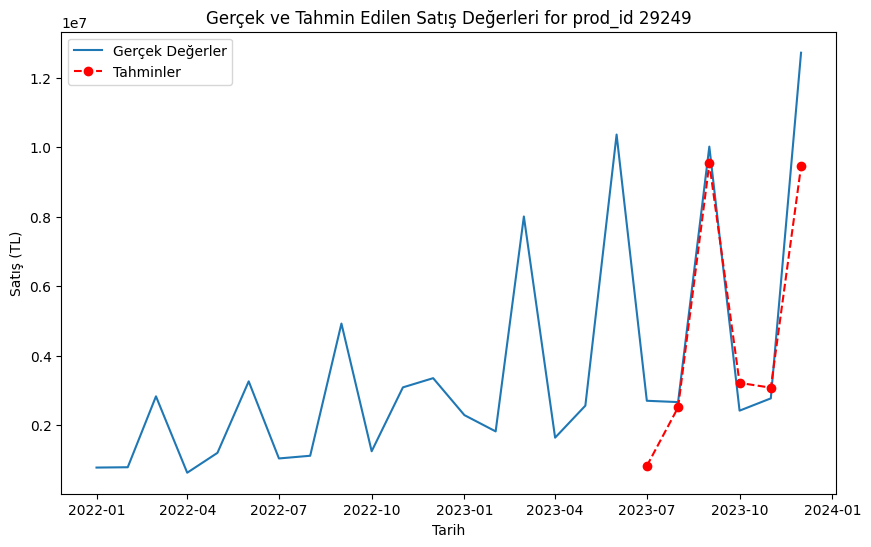

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model Tahminleri for prod_id 29249:
2024-01-01    1.859698e+06
2024-02-01    3.204602e+06
2024-03-01    1.224140e+07
2024-04-01    2.051732e+06
2024-05-01    3.441552e+06
2024-06-01    1.183139e+07
Freq: MS, Name: predicted_mean, dtype: float64


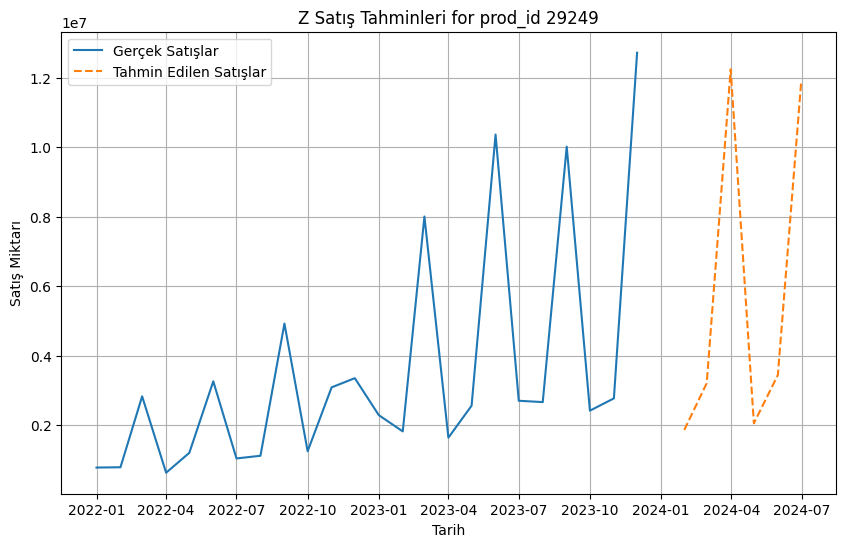

In [85]:
# TABS 550MG FORT 10 Z için:
process_sales_data(df_2022_2023_29249, 29249)


<ipython-input-83-f8460e3c9492>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["units"], color='y')


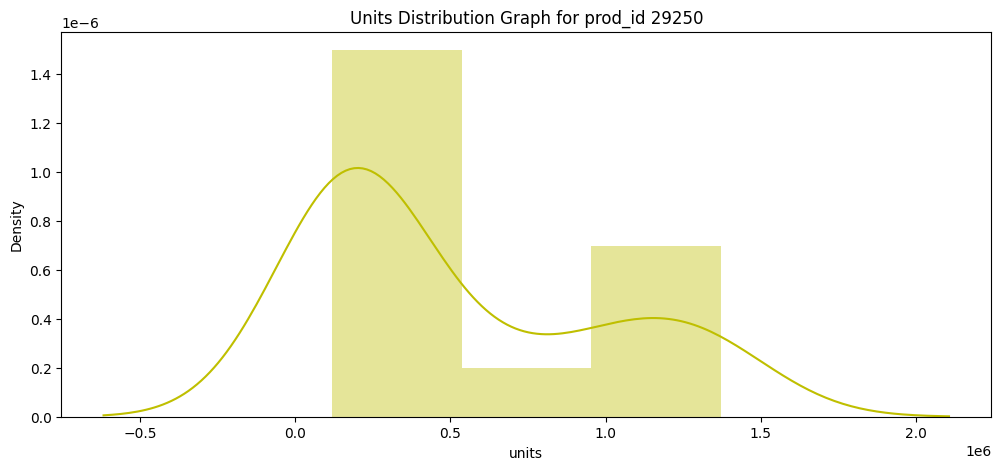

ADF Test Results for prod_id 29250:
1. ADF :  1.2120367630904079
2. P-Value :  0.9960679997990052
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression: 14
5. Critical Values :
	 1% :  -4.01203360058309
	 5% :  -3.1041838775510207
	 10% :  -2.6909873469387753
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=808.569, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=853.376, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=850.120, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=849.810, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=851.664, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=847.086, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=807.046, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=845.710, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=807.107, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=808.731, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=11988154.524085253, expected=8067024.9
predicted=10609410.308969215, expected=11542406.04
predicted=48236472.18223209, expected=66111002.82
MAE: 5144826.316393703
RMSE: 93317.02596182104
MAPE: 27.91559542910847


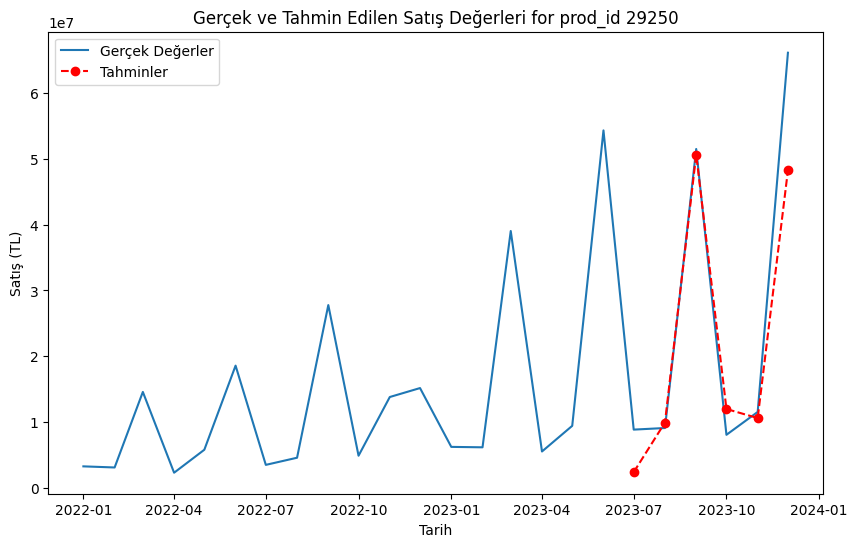

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model Tahminleri for prod_id 29250:
2024-01-01    6.498002e+06
2024-02-01    1.315527e+07
2024-03-01    6.389769e+07
2024-04-01    7.450621e+06
2024-05-01    1.429699e+07
2024-06-01    6.186219e+07
Freq: MS, Name: predicted_mean, dtype: float64


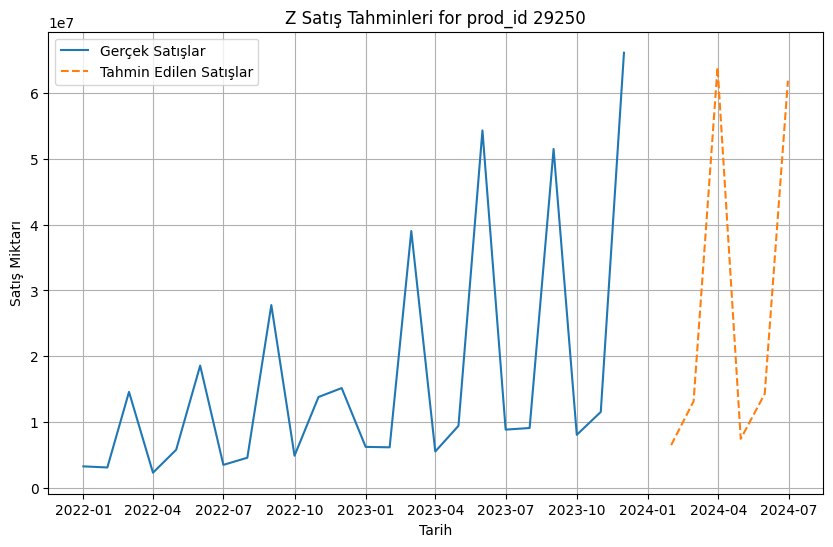

In [86]:
# TABS 550MG FORT 20 Z için:
process_sales_data(df_2022_2023_29250, 29250)